# Identifying Entities in Healthcare Data

## Workspace set up: Import and Install useful packages.

In [1]:
#!pip install pycrf
#!pip install sklearn-crfsuite

import warnings
warnings.filterwarnings('ignore')

import numpy as np, pandas as pd
import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics

model = spacy.load("en_core_web_sm")

##Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line. 
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**


### Construct the proper sentences from individual words and print the 5 sentences.

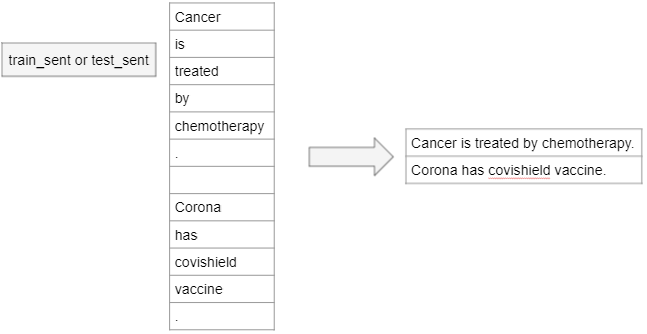

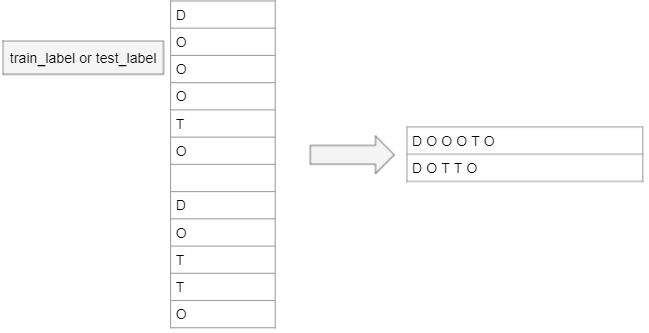

In [2]:
# Lets read the given data

with open('train_sent', 'r') as train_sent_data:
    train_words = train_sent_data.readlines()
    
with open('train_label', 'r') as train_labels_data:
    train_label_word = train_labels_data.readlines()
    
with open('test_sent', 'r') as test_sent_data:
    test_words = test_sent_data.readlines()
    
with open('test_label', 'r') as test_labels_data:
    test_lables_word  = test_labels_data.readlines()

In [3]:
# lets define a function

def to_sent(data):
    sent_lst = []
    sent = ''
    for x in data:
        if x != '\n':
            sent = sent + x[:-1] + ' '
        else:
            sent_lst.append(sent[:-1])
            sent = ''
    return sent_lst

In [4]:
# Lets align the data

train_sent = to_sent(train_words)
train_labels = to_sent(train_label_word)
test_sent = to_sent(test_words)
test_labels = to_sent(test_lables_word)

### Count the number of sentences in the processed train and test dataset 

In [5]:
print(f'Number of sentences in the processed Train Data - {len(train_sent)}')
print(f'Number of sentences in the processed Test Data - {len(test_sent)}')
print(f'Number of sentences in both processed Train and Test data - {(len(train_sent) + (len(test_sent)))}')

Number of sentences in the processed Train Data - 2599
Number of sentences in the processed Test Data - 1056
Number of sentences in both processed Train and Test data - 3655


### Count the number of lines of labels in the processed train and test dataset.

In [6]:
print(f'Number of lines of labels in the processed Train Data - {len(train_labels)}')
print(f'Number of lines of labels in the processed Test Data - {len(test_labels)}')
print(f'Number of lines of labels in both processed Train and Test Data - {(len(train_labels) + (len(test_labels)))}')

Number of lines of labels in the processed Train Data - 2599
Number of lines of labels in the processed Test Data - 1056
Number of lines of labels in both processed Train and Test Data - 3655


##Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging. 



### Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

In [7]:
clubb_data = train_sent + test_sent

In [8]:
# Lets chekc the total number of values

print(len(clubb_data))

3655


In [26]:
# Using defining function, lets filter the elements with 'NOUN' or 'PROPN' as its Pos Tag

noun_tag = []
propn_tag = []

for sent in clubb_data:
    doc = model(sent)
    for token in doc:
        if token.pos_ == 'NOUN':
            noun_tag.append(token.text.lower())
        elif token.pos_ == 'PROPN':
            propn_tag.append(token.text.lower())

In [10]:
# lets check the count

print(len(noun_tag))
print(len(propn_tag))

20557
3732


In [27]:
# noun tags
print(noun_tag)

['births', 'weeks', 'delivery', 'route', 'indication', 'age', 'parity', 'practice', 'group', 'risk', 'status', 'rate', '%', 'rate', '%', 'presentation', 'indication', '%', 'rate', 'medicine', 'patients', '%', 'rate', '%', 'arrest', 'dilation', 'indication', 'subgroups', '%', 'rates', 'care', 'hospitals', 'rates', 'community', 'hospitals', 'groups', 'age', 'trimester', 'index', 'status', 'temperature', 'increases', 'decrease', 'period', 'heat', 'women', 'singleton', 'pregnancies', 'weeks', 'gestation', 'testing', 'determinations', 'ambient', 'temperature', 'area', 'day', 'mean', 'temperature', 'test', 'date', 'rank', 'correlation', 'relationship', 'account', 'measure', 'being', 'study', 'population', 'women', 'diabetes', 'screening', 'women', 'clinic', 'year', 'period', 'women', '%', 'treatment', 'weeks', 'group', 'women', '%', 'treatment', 'week', 'group', 'patients', 'protocol', 'control', 'characteristics', 'groups', 'differences', 'groups', 'mode', 'delivery', 'scores', 'rate', 'inf

In [28]:
# Propn tags
print(propn_tag)

['university', 'vermont', 'afi', 'afi', 'june', 'august', 'afi', 'spearman', 'afi', 'hadassah', 'medical', 'center', 'apgar', 'edward', 'patau', 'edward', 'patau', 'new', 'york', 'hospital', 'cornell', 'medical', 'center', 'student', 'chi', 'square', 'eclampsia', '-', 'omphalocele', 'exstrophy', 'imperforate', 'oeis', 'omphalocele', 'nonimmune', 'chronic', 'progressive', 'external', 'ophthalmoplegia', 'kearns', 'sayre', 'context', 'alzheimer', 'presenilin', 'presenilin', 'n=280', 'national', 'insititute', 'neurological', 'disorders', 'stroke', 'alzheimer', 'disease', 'related', 'disorders', 'association', 'dna', 'main', 'outcome', 'measures', 'lod', 'peak', 'lod', 'n=54', 'n=54', '.03', '.14', 'd12s1057', 'd12s1042', 'mls', 'brca1', 'brca1', 'major', 'outcome', 'measures', 'brca1', 'exon', 'ashkenazi', 'brca1', 'hpc1', 'national', 'cancer', 'data', 'base', 'main', 'outcome', 'measures', 'hpc1', 'hpc1', 'serum', 'p=.01', 'p=.03', 'context', 'ms', 'hla', 'apoe', 'mbp', 'ms', 'california'

### Print the top 25 most common tokens with NOUN or PROPN PoS tags

In [11]:
#Top 25 Tokens with NOUN as PoS tag

print('--- Top 25 Tokens with NOUN as PoS tag ---')
print(pd.Series(noun_tag).value_counts().head(25))

--- Top 25 Tokens with NOUN as PoS tag ---
patients        507
treatment       304
%               247
cancer          204
therapy         177
study           160
disease         140
cell            138
lung            117
results         105
effects          99
group            93
chemotherapy     91
gene             91
effect           82
women            81
analysis         76
risk             74
use              74
surgery          73
cases            72
rate             68
response         66
survival         65
children         65
dtype: int64


In [12]:
# Top 25 Tokens with PROPN as PoS tag

print('-- Top 25 Tokens with PROPN as PoS tag --')
print(pd.Series(propn_tag).value_counts().head(25))

-- Top 25 Tokens with PROPN as PoS tag --
to_see           43
mg               37
c                30
hiv              29
methods          23
b                23
a                23
g                21
p                20
nsclc            19
s                18
serum            18
group            18
co2              17
cisplatin        15
hepatitis        15
american         14
aids             14
international    14
csf              14
interferon       14
hodgkin          14
l.               13
ii               13
use              13
dtype: int64


## Defining features for CRF





### Features

    f1 = is word in lower case
    f2 = last 3 characters
    f3 = last 2 characters
    f4 = 1 if the word is in uppercase else 0
    f5 = 1 if word is a digit else 0
    f6 = 1 if word starts with capital letter else 0
    f7 = PoS tag

In [13]:
# Let's define the features to get the feature value for one word.

def get_feature_for_word(sentence, pos, tag_list):
    word = sentence[pos]
    tag = tag_list[pos]
    
    features = [
        'word.lower =' + word.lower(),
        'word[-3:] =' + word[-3:],
        'word[-2:] =' + word[-2:],
        'word.isupper =%s' % word.isupper(),
        'word.isdigit = %s' % word.isdigit(),
        'word.StartsWithCapital = %s' % word[0].isupper(),
        'word.postag =' + tag
    ]
    
    if pos > 0:
        pre_word = sentence[pos-1]
        features.extend([
            'pre_word.lower =' + pre_word.lower(),
            'pre_word.isupper = %s' % pre_word.isupper(),
            'pre_word.isdigit = %s' % pre_word.isdigit(),
            'pre_word.StartsWithCapital = %s' % pre_word[0].isupper(),
            'pre_word.postag =' + tag
        ])
    else:
        features.append('BEG')
        
    if pos == len(sentence)-1:
        features.append('END')
        
    return features

## Getting the features

### Write a code/function to get the features for a sentence

In [14]:
# Write a code to get features for a sentence.

def get_feature_for_sent(sent):
    doc = model(sent)
    tag_list = []
    for token in doc:
        tag_list.append(token.pos_)
    sent_list = sent.split()
    return [get_feature_for_word(sent_list, pos, tag_list) for pos in range(len(sent_list))]

In [15]:
# Lets chek the defined code

sent1 = train_sent[50]
print(sent1)
print(' ')
features = get_feature_for_sent(sent1)
print(features[7])
print(' ')
print(features[0])

DESIGN : A complete genomic screen was performed ( N=280 markers )
 
['word.lower =performed', 'word[-3:] =med', 'word[-2:] =ed', 'word.isupper =False', 'word.isdigit = False', 'word.StartsWithCapital = False', 'word.postag =VERB', 'pre_word.lower =was', 'pre_word.isupper = False', 'pre_word.isdigit = False', 'pre_word.StartsWithCapital = False', 'pre_word.postag =VERB']
 
['word.lower =design', 'word[-3:] =IGN', 'word[-2:] =GN', 'word.isupper =True', 'word.isdigit = False', 'word.StartsWithCapital = True', 'word.postag =VERB', 'BEG']


### Write a code/function to get the labels of a sentence

In [16]:
# Write a code to get the labels for a sentence.

def get_labels_for_sent(labels):
    return labels.split()

In [17]:
# Lets check the defined code

print(get_labels_for_sent(train_labels[21]))

['D', 'D', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'D', 'D', 'O', 'O', 'O', 'O', 'O', 'D', 'D', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


## Define input and target variables


Correctly computing X and Y sequence matrices for training and test data.
Check that both sentences and labels are processed

### Define the features' values for each sentence as input variable  for CRF model in test and the train dataset 

In [18]:
X_train = [get_feature_for_sent(sent) for sent in train_sent]
X_test = [get_feature_for_sent(sent) for sent in test_sent]

### Define the labels as the target variable for test and the train dataset

In [19]:
y_train = [get_labels_for_sent(labels) for labels in train_labels]
y_test = [get_labels_for_sent(labels) for labels in test_labels]

## Build the CRF Model

In [20]:
# Build the CRF model.
try:
    crf = sklearn_crfsuite.CRF(max_iterations = 300)
    crf.fit(X_train, y_train)
except AttributeError:
    pass

## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [21]:
y_pred = crf.predict(X_test)

### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [22]:
metrics.flat_f1_score(y_test, y_pred, average = 'weighted')

0.9117114278902213

##Identifying Diseases and Treatments using Custom NER

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.



### Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

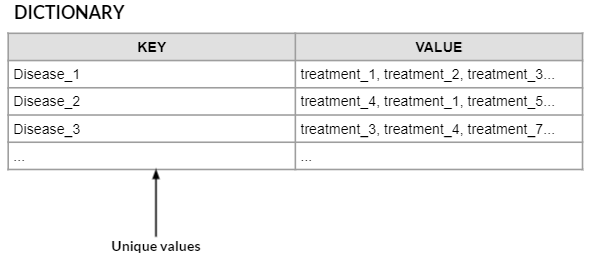

In [23]:
disease = []
treatment = []

treatment_guide = {}

for x in range(len(y_pred)):
    for y in range(len(y_pred[x])):
        test = test_sent[x].split()
        if y_pred[x][y] == 'D':
            disease.append(test[y])
        elif y_pred[x][y] == 'T':
            treatment.append(test[y])
            
    key = ' '.join(disease)
    value = ', '.join(treatment)
    
    if key != '':
        if treatment != []:
            treatment_guide[key] = value
            
    disease = []
    treatment = []

### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [29]:
input_disease = 'hereditary retinoblastoma'
output = treatment_guide[input_disease]

print(f'Treatment for {input_disease} is / are {output}')

Treatment for hereditary retinoblastoma is / are radiotherapy
